In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

import scipy 
from scipy import ndimage


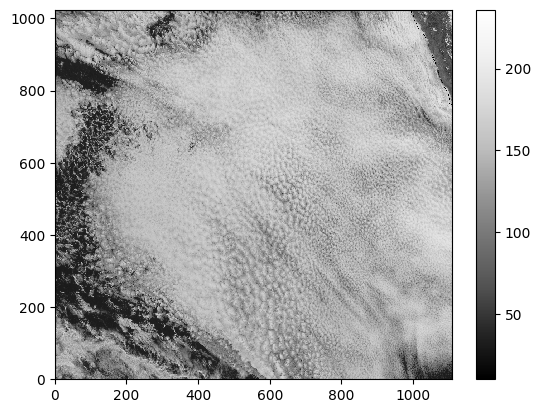

In [2]:


# Define the path to the directory containing the images
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
# Use glob to find the images in the specified path
fnames = np.sort(glob(path + '*9_06*png'))
images = []

# Read the images and process them
for i, fname in enumerate(fnames):
    img = imageio.v2.imread(fname)
    red = np.flipud(img[:, 400:, 0])
    images.append(red)  # Just red channel, just 400:end in the x dir, flip y

# Plot the first processed image
plt.pcolormesh(images[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [3]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)


# Pixel size: nominal for MKS units to pixel units 
DX = 2000             # m, pixel size (nominal)

# Xm and Ym are Coordinates in meters, distances measured from central point of image
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

## Wave parameters for warping and modulating an image
"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

For a wave moving toward 45 degrees (northeast), define k and l as positive (sin and cos of nav angle). Let's take z = sin( k(x-ct) + l(y-ct) ) which is indeed moving NEward with time. Then u and v are both positive at z crests (sketch it). That means dx and dy are positve when time is 1/4 period later, or when 90deg of phase have been subtracted since t appears with a negative sign in the formula for phase (x-ct).

In [4]:
# One wave packet 
cphase = 14            # m/s
wavelength = 150*1000. # meters
period = wavelength/cphase 
direction = 225       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k = 2*np.pi/wavelength * np.sin( (direction) *np.pi/180 )   
l = 2*np.pi/wavelength * np.cos( (direction) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x = -400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y = 400*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x  = 400*1000.  # meters
packet_width_y  = 300*1000.  # meters
Ampwindow = np.exp(-( ((Xm-packet_center_x)/packet_width_x)**2 + \
                      ((Ym-packet_center_y)/packet_width_y)**2 )) 
     
#plt.pcolormesh(Ampwindow); plt.colorbar()

In [5]:
# A second wave packet 
cphase2 = 20            # m/s
wavelength2 = 100*1000. # meters
period2 = wavelength2/cphase2 
direction2 = 140       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude2 = 50      # meters, vertical displacement
PBLdepth2 = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k2 = 2*np.pi/wavelength2 * np.sin( (direction2) *np.pi/180 )   
l2 = 2*np.pi/wavelength2 * np.cos( (direction2) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x2 = 400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y2 = 100*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x2  = 200*1000.  # meters
packet_width_y2  = 600*1000.  # meters
Ampwindow2 = np.exp(-( ((Xm-packet_center_x2)/packet_width_x2)**2 + \
                      ( (Ym-packet_center_y2)/packet_width_y2)**2 )) 

### Animation displays for time-dependent warped imagery texture

In [6]:
# Constants for this animation 
time_steps = 10            # Number of time steps 
time_resolution = 1800     # seconds, images are half an hour apart

# The resulting image arrays, for animation 
grid = np.zeros((height, width, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for it in range(time_steps):
    t = it*time_resolution     # t is in seconds 

# dz measures vertical displacements: let's choose the sine function. Two packets 
    dz = zamplitude \
         * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) ) *Ampwindow 
    dz2 = zamplitude2 \
         * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) ) *Ampwindow2

# wave dx and dy are 90deg behind phase with dz, prop. to wavelength. 
# DIRECTION: For 45deg (wave going NE), k>0,l>0, dx>0,dy>0 (sketch it). 

    dxy = (zamplitude/PBLdepth)*wavelength \
          * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) -np.pi/2.) /DX
    dx = dxy * np.sin(direction *np.pi/180.) *Ampwindow # why /2? because it is too strong. Pixel units?? 
    dy = dxy * np.cos(direction *np.pi/180.) *Ampwindow

    dxy2= (zamplitude2/PBLdepth2)*wavelength2 \
          * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) -np.pi/2.) /DX
    dx2= dxy2* np.sin(direction2 *np.pi/180.) *Ampwindow2 
    dy2= dxy2* np.cos(direction2 *np.pi/180.) *Ampwindow2

# Warping by transporting pixels in original red image, wrapping (periodic) for now. SUBTRACT dy and dx in argument. 
    grid[:,:,it] = ndimage.map_coordinates(images[it],[Y-dy-dy2, X-dx-dx2])  

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    grid[:,:,it] *= (1 + dz /PBLdepth  *5) 
    grid[:,:,it] *= (1 + dz2/PBLdepth2 *5) 

maxvalue = grid.max()
maxvalue

309.58694301653907

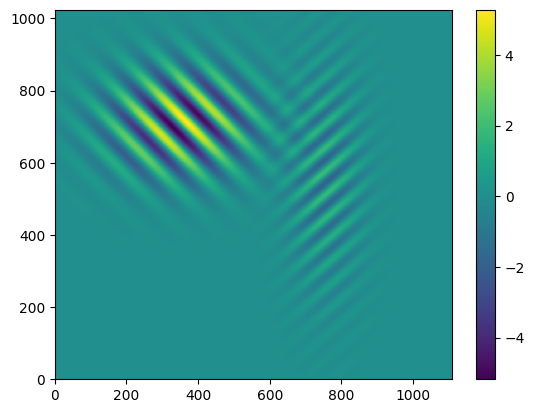

In [7]:
plt.pcolormesh(dy+dy2); plt.colorbar(); # pixels units -- surprising that 7 pixels make such a huge warp?

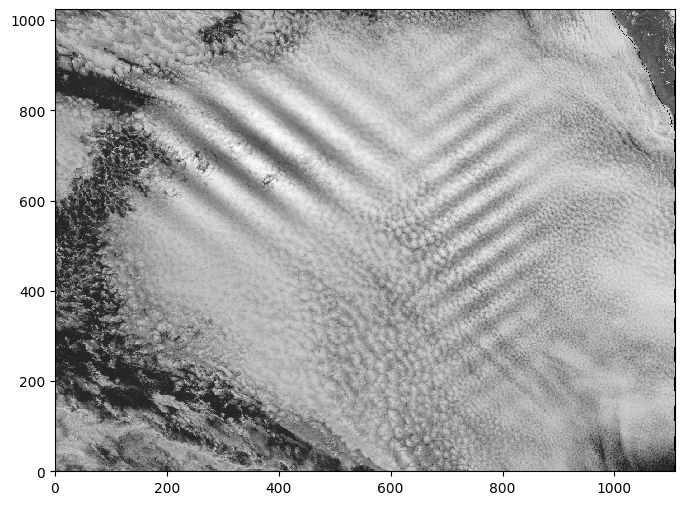

In [8]:
plt.figure(figsize=(8,6))
plt.pcolormesh(grid[:,:,0], cmap='Greys_r')

# S-transform Approach

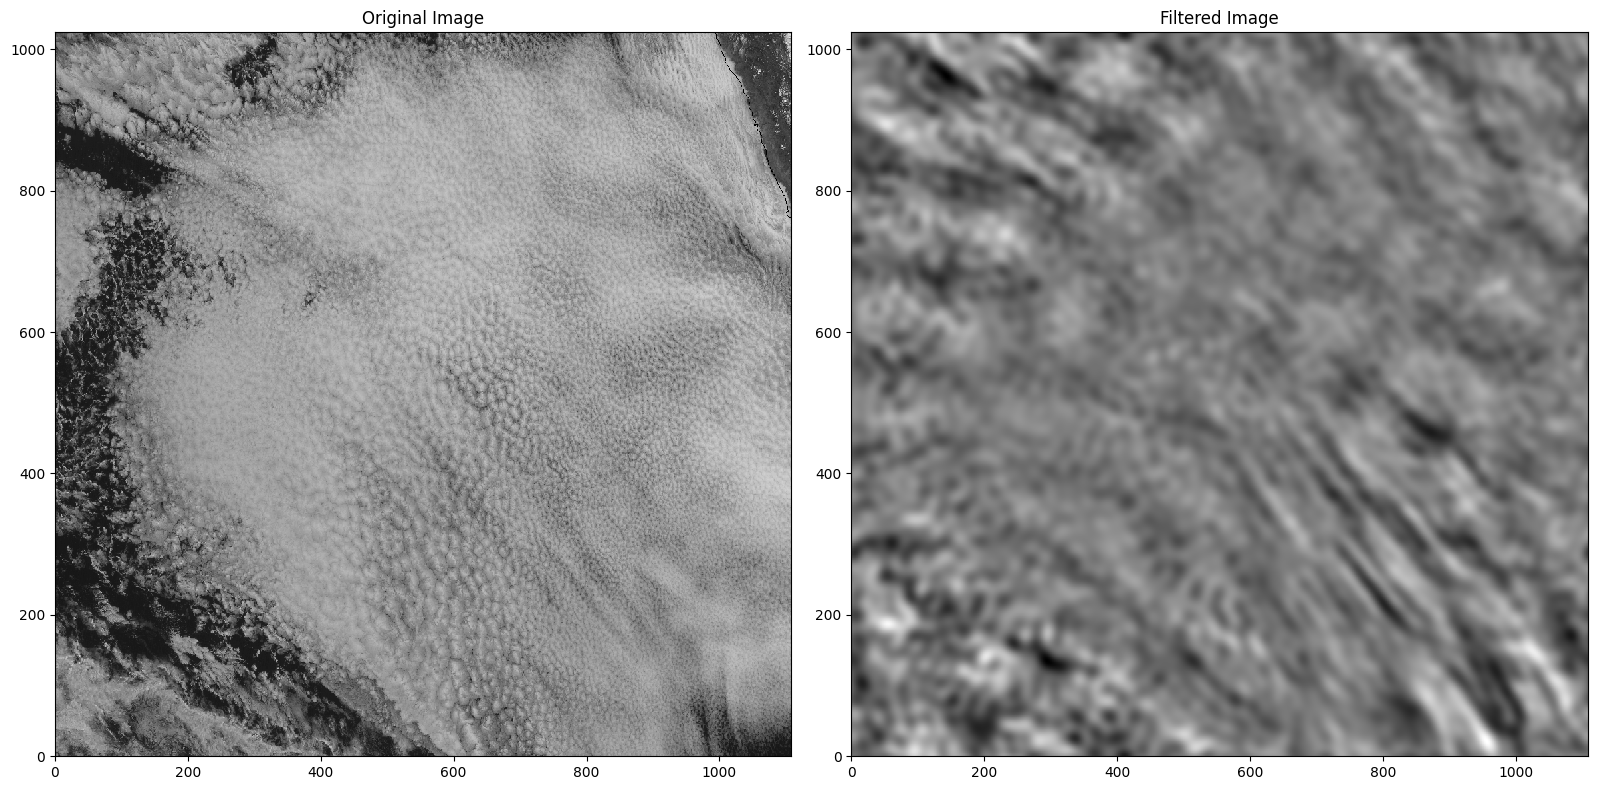

In [9]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

# circular permutation of the dimensions until the third one is the time dimension
images = np.moveaxis(images, 2, 0)
images = np.moveaxis(images, 2, 0)

images_filtered = filter_frames(images, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(images,images[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

Shape of ST_C: (1024, 1024)
Shape of ST_A: (1024, 1024)
Shape of ST_R: (1024, 1024)
Shape of ST_F1: (1024, 1024)
Shape of ST_F2: (1024, 1024)
Shape of ST_HA: (1024, 1024)
Shape of ST_HR: (1024, 1024)
Shape of ST_full: (1024, 1024, 100)


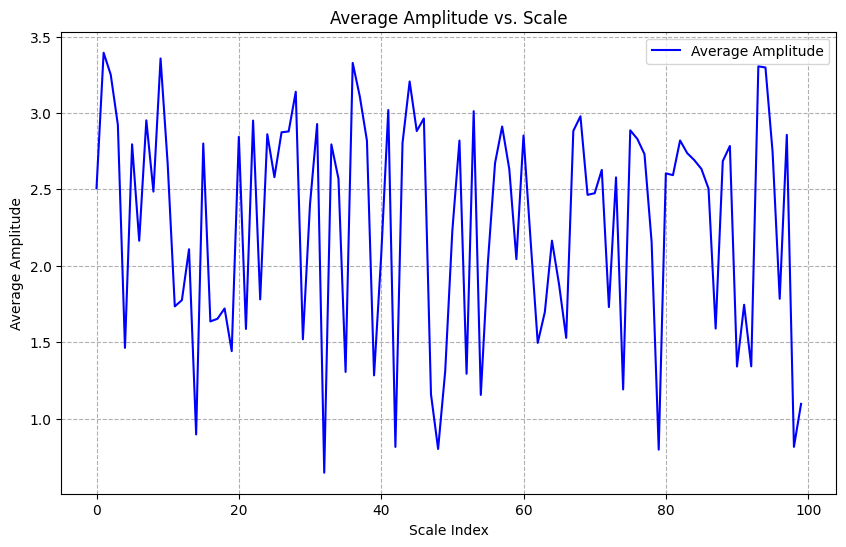

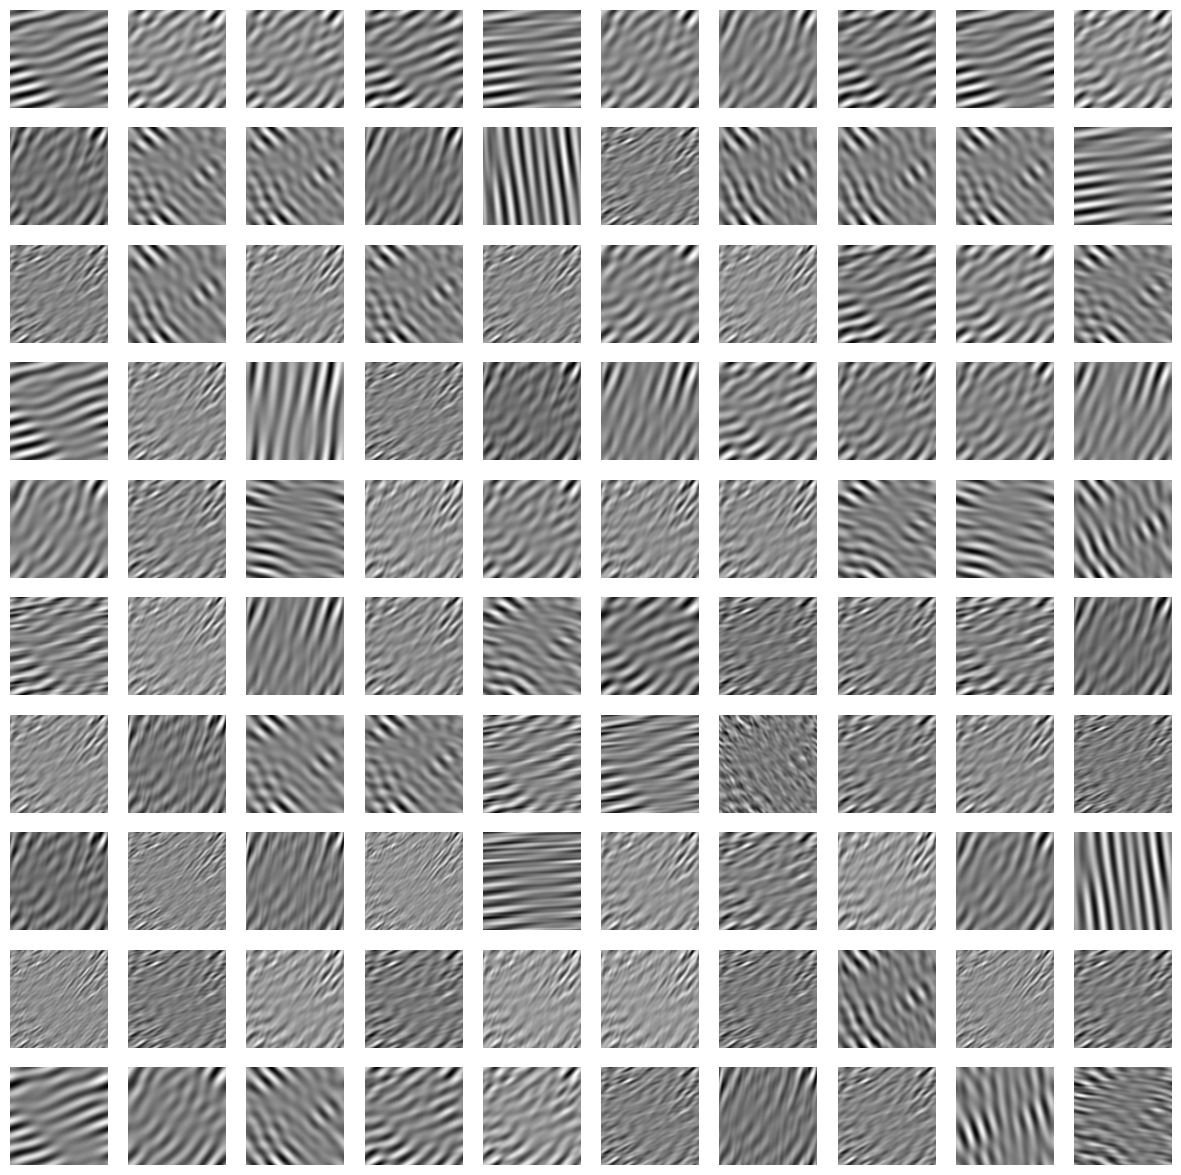

In [23]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Add the path to your MATLAB function directory
eng.addpath(r'C:\Users\ratynski\Documents\MATLAB\Matfiles', nargout=0)

# Get the image
image = images_filtered[:, :, 0]
# Ensure the image is square
image = image[:image.shape[0], :image.shape[0]]

# Define input parameters for S Transform
scales = 100  # Setting the number of scales
point_spacing = [1, 1]  # Example point spacing
c = [0.25, 0.25]  # Example scaling parameter

# Convert numpy arrays to MATLAB arrays
image_matlab = matlab.double(image.tolist())
point_spacing_matlab = matlab.double(point_spacing)
c_matlab = matlab.double(c)

# Call the MATLAB function
ST = eng.nph_ndst(image_matlab, scales, point_spacing_matlab, c_matlab, 'full')

# Extract the outputs
ST_C = np.array(ST['C'])
ST_A = np.array(ST['A'])
ST_R = np.array(ST['R'])
ST_F1 = np.array(ST['F1'])
ST_F2 = np.array(ST['F2'])
ST_HA = np.array(ST['HA'])
ST_HR = np.array(ST['HR'])

# Stop MATLAB engine
eng.quit()

# Extract the full spectrum
ST_full = np.array(ST['ST'])
print("Shape of ST_full:", ST_full.shape)

# Compute the average amplitude for each scale
#average_amplitudes = np.mean(np.abs(ST_full), axis=(0, 1))
average_amplitudes = ST_full(256,256,:)
scale_indices = np.arange(len(average_amplitudes))

# Plot the average amplitude for each scale
plt.figure(figsize=(10, 6))
plt.plot(scale_indices, average_amplitudes, label='Average Amplitude', color='b')
plt.xlabel('Scale Index')
plt.ylabel('Average Amplitude')
plt.title('Average Amplitude vs. Scale')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# If ST_R represents the reconstruction for each scale, plot an image showing the combinations of all the scales
if ST_full.ndim == 3:
    errors = []
    N = 10
    fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
    for level in range(min(N * N, ST_full.shape[2])):
        i = level // N
        j = level % N
        plt.sca(axes[i, j])
        plt.axis('off')
        reconstruction = np.real(ST_full[:, :, level])
        reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
        errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))
        plt.imshow(reconstruction, cmap='gray')
    plt.show()
else:
    print("The function did not return multiple reconstructions.")


Shape of ST_full: (1024, 1024, 100)


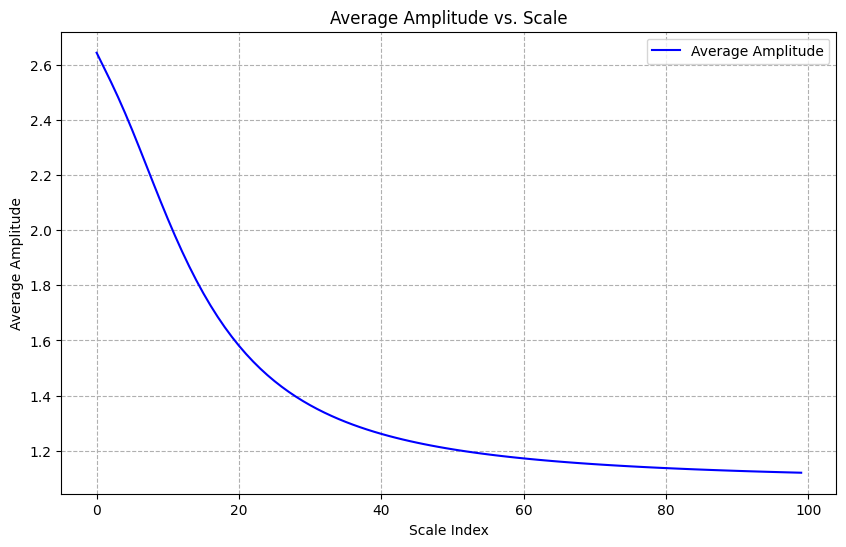

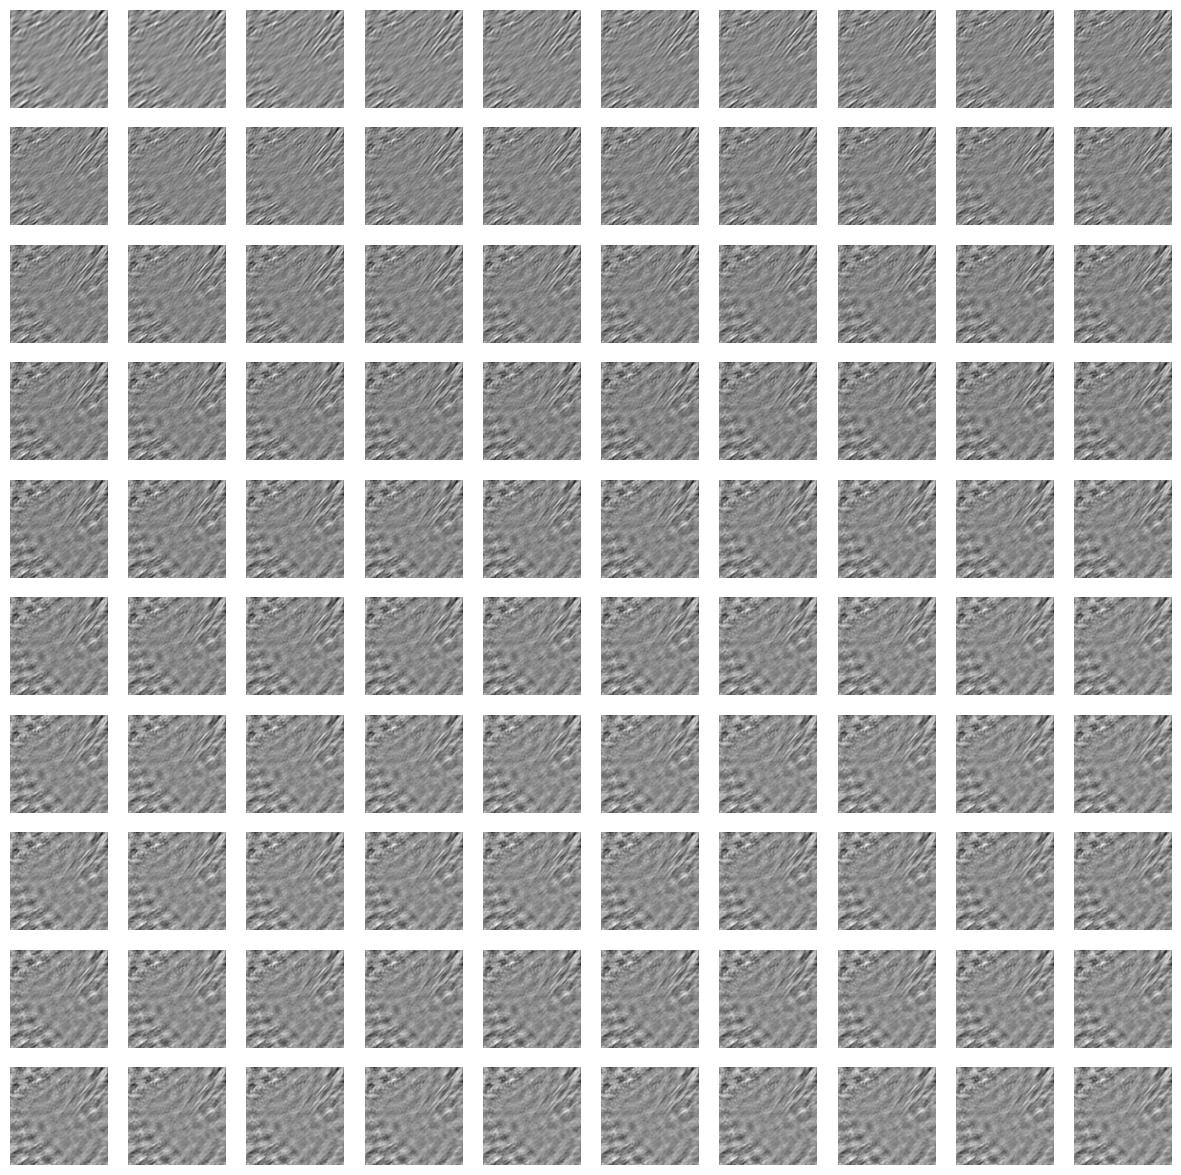

In [27]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start MATLAB engine
eng = matlab.engine.start_matlab()

# Add the path to your MATLAB function directory
eng.addpath(r'C:\Users\ratynski\Documents\MATLAB\Matfiles', nargout=0)

# Get the image
image = images_filtered[:, :, 0]
# Ensure the image is square
image = image[:image.shape[0], :image.shape[0]]

# Define input parameters for S Transform
min_scale = 15
max_scale = 150
num_scales = 100  # Number of scales
scales = np.linspace(min_scale, max_scale, num_scales)  # Setting the scale range
scales = np.vstack((scales, scales))  # Create a 2-by-N vector for the 2D input
point_spacing = [1, 1]  # Example point spacing
c = [0.25, 0.25]  # Example scaling parameter

# Convert numpy arrays to MATLAB arrays
image_matlab = matlab.double(image.tolist())
scales_matlab = matlab.double(scales.tolist())
point_spacing_matlab = matlab.double(point_spacing)
c_matlab = matlab.double(c)

# Call the MATLAB function
ST = eng.nph_ndst(image_matlab, scales_matlab, point_spacing_matlab, c_matlab, 'full')

# Extract the outputs
ST_C = np.array(ST['C'])
ST_A = np.array(ST['A'])
ST_R = np.array(ST['R'])
ST_F1 = np.array(ST['F1'])
ST_F2 = np.array(ST['F2'])
ST_HA = np.array(ST['HA'])
ST_HR = np.array(ST['HR'])

# Stop MATLAB engine
eng.quit()

# Extract the full spectrum
ST_full = np.array(ST['ST'])
print("Shape of ST_full:", ST_full.shape)

# Compute the average amplitude for each scale
average_amplitudes = np.mean(np.abs(ST_full), axis=(0, 1))
scale_indices = np.arange(len(average_amplitudes))

# Plot the average amplitude for each scale
plt.figure(figsize=(10, 6))
plt.plot(scale_indices, average_amplitudes, label='Average Amplitude', color='b')
plt.xlabel('Scale Index')
plt.ylabel('Average Amplitude')
plt.title('Average Amplitude vs. Scale')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# If ST_R represents the reconstruction for each scale, plot an image showing the combinations of all the scales
if ST_full.ndim == 3:
    errors = []
    N = 10
    fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
    for level in range(min(N * N, ST_full.shape[2])):
        i = level // N
        j = level % N
        plt.sca(axes[i, j])
        plt.axis('off')
        reconstruction = np.real(ST_full[:, :, level])
        reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
        errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))
        plt.imshow(reconstruction, cmap='gray')
    plt.show()
else:
    print("The function did not return multiple reconstructions.")


C:\Users\ratynski\AppData\Local\Temp\ipykernel_34712\2503430634.py:31: RuntimeWarning: invalid value encountered in divide
  reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())


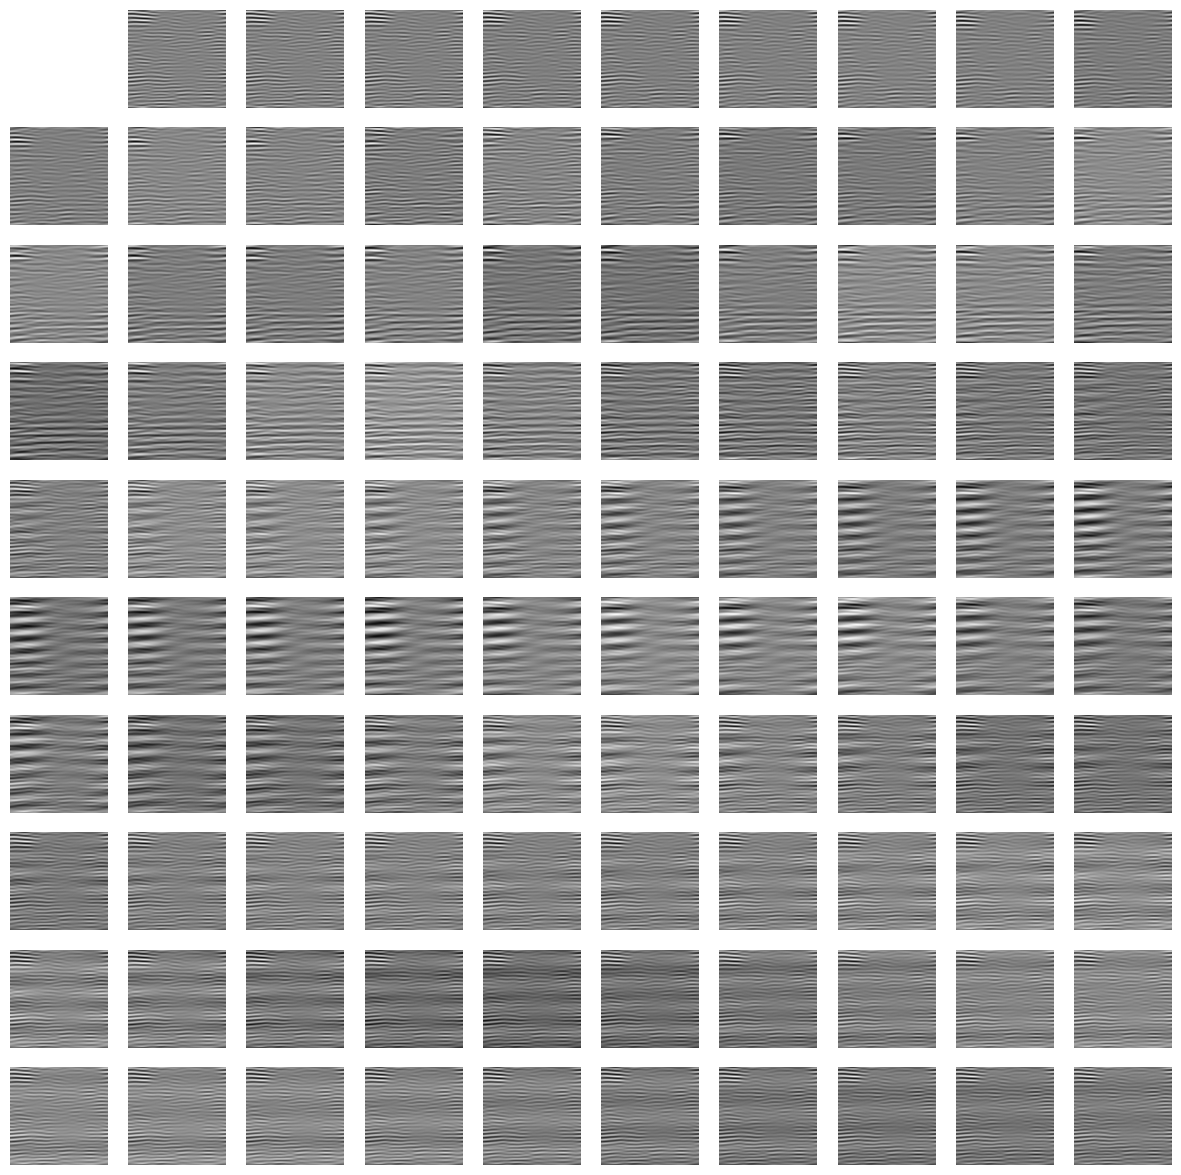

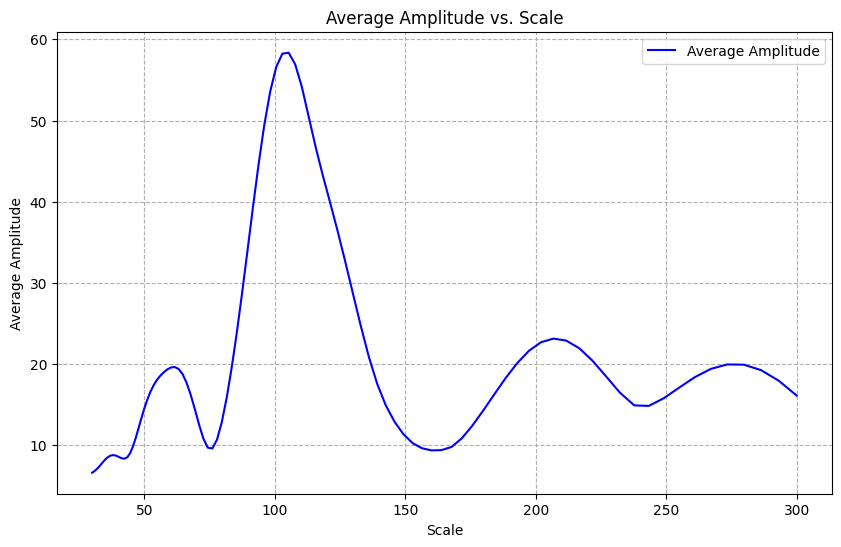

In [41]:
import numpy as np
import pywt
from matplotlib import pylab as plt
import py_cwt2d

# Get the image
image = images_filtered[:,:,0]
# ensure the image is square
image = image[:image.shape[0], :image.shape[0]]
# image = pywt.data.camera()
# image = (image - image.min()) / (image.max() - image.min())

# Set up a range of scales 
ss = np.geomspace(30, 300, 100)
#ss = np.geomspace(1.0, 256.0, 100)

# Calculate the complex pycwt and the wavelet normalizations
coeffs, wav_norm = py_cwt2d.cwt_2d(image, ss, 'cmor')  # Ensure 'cmor' from the updated wavelets dictionary is added manually

# Plot an image showing the combinations of all the scales
errors = []
N = 10
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
for level in range(len(ss)):
    i = level // N
    j = level % N
    plt.sca(axes[i, j])
    plt.axis('off')
    C = 1.0 / (ss[:level] * wav_norm[:level])
    reconstruction = (C * np.real(coeffs[..., :level])).sum(axis=-1)
    reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))
    plt.imshow(reconstruction, cmap='gray')
plt.show()

# fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6 / 1.618))
# plt.plot(errors, label='norm')
# plt.xlabel('Number of Reconstruction Scales')
# plt.ylabel('Reconstruction Error')
# plt.show()

# Compute the average amplitude for each scale
average_amplitudes = np.zeros(len(ss))

for i, scale in enumerate(ss):
    avg_amplitude = np.mean(np.abs(coeffs[..., i]))
    average_amplitudes[i] = avg_amplitude

# Plot the average amplitude for each scale
plt.figure(figsize=(10, 6))
plt.plot(ss, average_amplitudes, label='Average Amplitude', color='b')
# plt.xscale('log')  # Log scale for x-axis to match the scale range
# plt.yscale('log')  # Log scale for y-axis to emphasize variations
plt.xlabel('Scale')
plt.ylabel('Average Amplitude')
plt.title('Average Amplitude vs. Scale')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


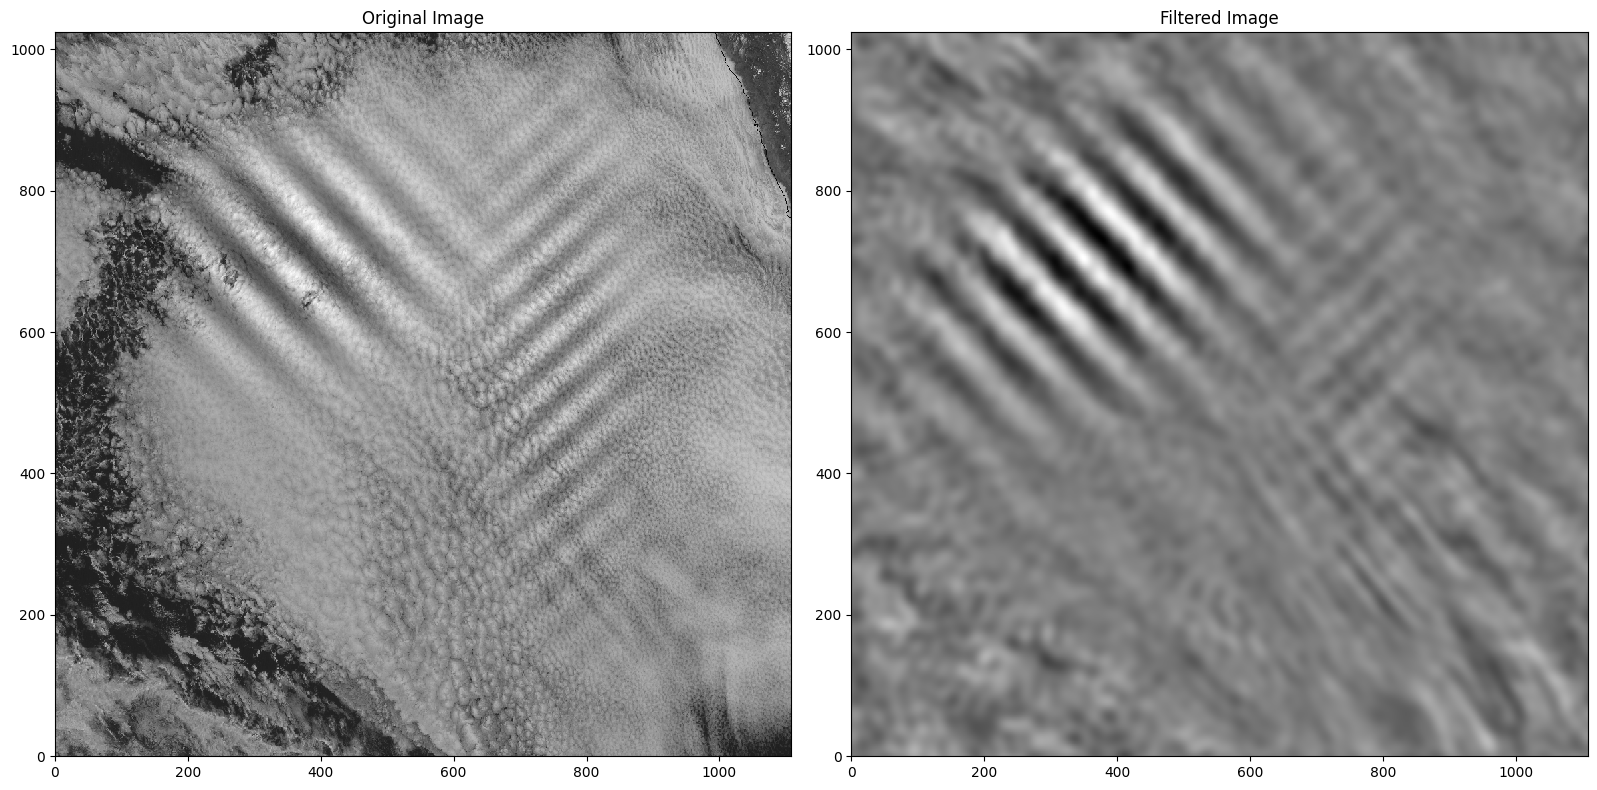

In [ ]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

images_filtered = filter_frames(grid, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(grid,grid[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)